# Classification with Naive Bayes

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Assignment 1

Name: Rui Zhang

Student ID: u5963436

## Instructions

|             |Notes|
|:------------|:--|
|Maximum marks| 19|
|Weight|19% of final grade|
|Format| Complete this ipython notebook. Do not forget to fill in your name and student ID above|
|Submission mode| Use [wattle](https://wattle.anu.edu.au/)|
|Formulas| All formulas which you derive need to be explained unless you use very common mathematical facts. Picture yourself as explaining your arguments to somebody who is just learning about your assignment. With other words, do not assume that the person marking your assignment knows all the background and therefore you can just write down the formulas without any explanation. It is your task to convince the reader that you know what you are doing when you derive an argument. Typeset all formulas in $\LaTeX$.|
| Code quality | Python code should be well structured, use meaningful identifiers for variables and subroutines, and provide sufficient comments. Please refer to the examples given in the tutorials. |
| Code efficiency | An efficient implementation of an algorithm uses fast subroutines provided by the language or additional libraries. For the purpose of implementing Machine Learning algorithms in this course, that means using the appropriate data structures provided by Python and in numpy/scipy (e.g. Linear Algebra and random generators). |
| Late penalty | For every day (starts at midnight) after the deadline of an assignment, the mark will be reduced by 20%. No assignments shall be accepted if it is later than 5 days. | 
| Cooperation | All assignments must be done individually. Cheating and plagiarism will be dealt with in accordance with University procedures (please see the ANU policies on [Academic Honesty and Plagiarism](http://academichonesty.anu.edu.au)). Hence, for example, code for programming assignments must not be developed in groups, nor should code be shared. You are encouraged to broadly discuss ideas, approaches and techniques with a few other students, but not at a level of detail where specific solutions or implementation issues are described by anyone. If you choose to consult with other students, you will include the names of your discussion partners for each solution. If you have any questions on this, please ask the lecturer before you act. |
| Solution | To be presented in the tutorials. |

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$
$\newcommand{\B}[1]{\mathbf{#1}}$
$\newcommand{\Bphi}{\boldsymbol{\mathsf{\phi}}}$
$\newcommand{\BPhi}{\boldsymbol{\Phi}}$
$\newcommand{\Cond}{\,|\,}$
$\newcommand{\DNorm}[3]{\mathcal{N}(#1\Cond#2, #3)}$
$\newcommand{\DUniform}[3]{\mathcal{U}(#1 \Cond #2, #3)}$
$\newcommand{\Ex}[2][]{\mathbb{E}_{#1} \left[ #2 \right]}$
$\newcommand{\var}[1]{\operatorname{var}[#1]}$
$\newcommand{\cov}[1]{\operatorname{cov}[#1]}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\DeclareMathOperator*{\argmax}{arg\,max}$

Setting up the environment (Please evaluate this cell to activate the $\LaTeX$ macros.)

In [14]:
import csv, scipy, scipy.stats, collections, itertools
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=False)
%matplotlib inline

## The data set


The data set contains census information. Our task is to predict whether an indivual earns more than some amount.

Please download the following data:
* https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

Read and preprocess the data.

In [15]:
raw_data = np.genfromtxt("adult.data", dtype=str, delimiter=',', autostrip=True)

# targets
target = ">50K"
target_column = raw_data[:,-1]
Y = (target_column == target).reshape(-1,1)
assert any(Y) and any(~Y), set(target_column)

features = [
    'age', 'workclass', 'fnlwgt','education', 'education_num', 'marital_status', 
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
    'hours_per_week', 'native_country'
]

raw_features = raw_data[:,:-1] # drop the target
assert raw_features.shape[1] == len(features)


def preprocess_continuous(column):
    # convert continuous variables stored as strings to binary by comparing with the median
    float_column = column.astype(float)
    return (float_column > np.median(float_column)).astype(float).reshape(-1,1)


def preprocess_categorical(column):
    # convert categorical variables to indicator vectors
    values = sorted(set(column))
    if len(values) == 2:
        values = values[:1]
    return np.hstack([column.reshape(-1,1)==v for v in values]).astype(float)

preprocessor = collections.defaultdict(lambda: preprocess_categorical)
preprocessor.update(dict(
    age=preprocess_continuous, 
    fnlwgt=preprocess_continuous, 
    education_num=preprocess_continuous,
    capital_gain=preprocess_continuous, 
    capital_loss=preprocess_continuous, 
    hours_per_week=preprocess_continuous,
))

# apply appropriate preprocessor to each column of raw_features
X_list = [preprocessor[feature](raw_features[:,features.index(feature)]) for feature in features]
for feature, X in zip(features, X_list):
    assert X.shape[0] == raw_features.shape[0]
    print(X.shape[1], '\t', feature)
    
make_feature_names = lambda feature, dimension: ['%s_%.2i' % (feature, i) for i in range(dimension)]
binary_feature_names_list = [make_feature_names(feature, X.shape[1]) for feature, X in zip(features, X_list)]
binary_feature_names = list(itertools.chain(*binary_feature_names_list))

X = np.hstack(X_list)
assert set(X.flatten()) == {0.0, 1.0}
assert len(binary_feature_names) == X.shape[1]

1 	 age
9 	 workclass
1 	 fnlwgt
16 	 education
1 	 education_num
7 	 marital_status
15 	 occupation
6 	 relationship
5 	 race
1 	 sex
1 	 capital_gain
1 	 capital_loss
1 	 hours_per_week
42 	 native_country


Plot the data.


X.shape 	 (32561, 107)
Y.shape 	 (32561, 1)

mean(Y) 0.240809557446


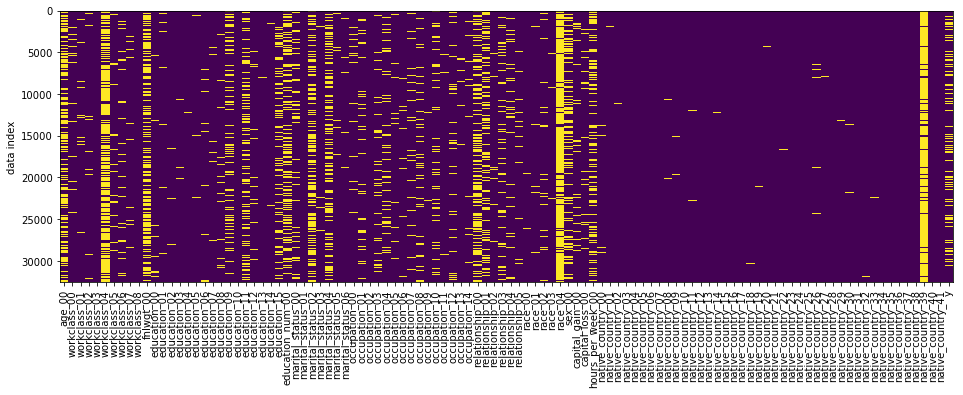

In [16]:
print('')
print('X.shape', '\t', X.shape)
print('Y.shape', '\t', Y.shape)
print()
print('mean(Y)', np.mean(Y))

figure = lambda : plt.figure(figsize=(16,5))
figure()
plt.imshow(np.hstack((X,Y)))
plt.axis('auto')
plt.ylabel('data index');
plt.gca().set_xticks(list(range(X.shape[1]+1)))
plt.gca().set_xticklabels(binary_feature_names+['y'], rotation='vertical')

ntrain = 1200
ishuffle = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(ishuffle)
itrain = ishuffle[slice(0,ntrain)]
itest = ishuffle[slice(ntrain,None)]
X_train, Y_train = X[itrain,:], Y[itrain,:]
X_test, Y_test = X[itest,:], Y[itest,:]

## (3 points) 1A: Naive Bayes: Maximum Likelihood (m.l.)
Assume we have dataset $\mathcal{D}=\left\{(\mathbf{x}_i,y_i\right)\}_{i=1,2,\ldots,n}$ where $\mathbf{x}_i\in\{0,1\}^d$, $y_i\in\{0,1\}$, $n$ is the number of data points and $d$ the number of features.
1. State the independence assumption of the naive Bayes classifier.
- Appropriately assume Bernoulli random variables. Letting $p(x_j=1|y=k) = \rho_{j,k}$ for $k=0,1$ and $p(y=1)=\mu$, derive the maximum likelihood $\rho_{j,k}$ and $\mu$ (that is, the parameters which maximise the likelihood).
- Implement a function which computes these maximum likelihood parameters, and call it on ```X_train, Y_train```.
- Plot the $\rho_{j,k}$ (vertical) vs. $j$ (horizontal) using ```plt.plot``` with ```marker='.'```, labeling appropriately.
- Print the number of $\rho_{j,k}$ which are zero.
- Explain the problems which zero- (or one-) valued $\rho_{j,k}$ can lead to.

### <span style="color:blue">Answer</span>
1. Features are independent of each other given the class. Concretely, let's say $\mathbf{x_i} = (x_{i,1},x_{i,2},...,x_{i,d})$ and the independence assumption conveys that the $d$ features are independent of each other conditioned on the class label.

2. Given the set of {$\rho_{j,k}$}, $j = 1,2,...,d$, $k = 0, \,1$, and $\mu$, the likelihood can be written as:
\begin{align}
P(D|{\rho_{j,k}}, \mu) &= \prod_{i = 1}^{n} P((\mathbf{x_i}, y_j) | {\rho_{j,k}}, \mu) \,\,\,(Different\, data\, are\, independent)\\
&= \prod_{i = 1}^{n} P(\mathbf{x_i} | y_j, {\rho_{j,k}}, \mu)P(y_j) \,\,\,(Bayes' rule)\\
\end{align}
To simplify the calculation, here log-likelihood is used to derive the optimal parameters:
\begin{align}
L(\{\rho_{j,k}\}, \mu) &= \ln P(D|{\rho_{j,k}}, \mu) \\
&= \sum_{i = 1}^{n} \ln P(\mathbf{x_i} | y_j, {\rho_{j,k}}, \mu) +\sum_{i = 1}^{n} \ln P(y_j)\\
&= \sum_{i = 1}^{n} [x_{i,j}\ln \rho_{j,1} + (1-x_{i,j})\ln(1-\rho_{j,1})]y_i+\sum_{i = 1}^{n} [x_{i,j}\ln \rho_{j,0} + (1-x_{i,j})\ln(1-\rho_{j,0})](1-y_i) + \sum_{i = 1}^{n} [y_i \ln \mu+(1-y_i) \ln(1-\mu)]
\end{align}
So, in order to get the maximum likelihood $\rho_{j,k}$ and $\mu$, calculate the partial derivative of $L(\{\rho_{j,k}\}, \mu)$ with respect to $\rho_{j,k}$ and $\mu$ seperately:
\begin{align}
\dfrac{\partial L(\{\rho_{j,k}\},\mu)}{\partial \rho_{j,1}} &= \sum_{i=1}^{n} (\dfrac{x_{i,j}}{\rho_{j,1}}-\dfrac{1-x_{i,j}}{1-\rho_{j,1}})y_i\\
&= \sum_{i=1}^{n}\dfrac{(x_{i,j}-\rho_{j,1})y_i}{\rho_{j,1}(1-\rho_{j,1})}\\
\dfrac{\partial L(\{\rho_{j,k}\},\mu)}{\partial \rho_{j,0}} &= \sum_{i=1}^{n} (\dfrac{x_{i,j}}{\rho_{j,0}}-\dfrac{1-x_{i,j}}{1-\rho_{j,0}})(1-y_i)\\
&= \sum_{i=1}^{n}\dfrac{(x_{i,j}-\rho_{j,0})(1-y_i)}{\rho_{j,0}(1-\rho_{j,0})}\\
\end{align}
Making the above partial derivative zero, we get $\rho_{j,1} = \dfrac{\sum_{i=1}^{n} x_{i,j}y_i}{\sum_{i=1}^n y_i}$ and $\rho_{j,0} = \dfrac{\sum_{i=1}^{n} x_{i,j}(1-y_i)}{\sum_{i=1}^n (1-y_i)}$. Note that $x_{i,j}$ represents the $j$-th feature in $x_i$. Consequently, in general,  $\rho_{j,1} = \dfrac{\sum_{i=1}^{n} x_{i,j}y_i}{\sum_{i=1}^n y_i}$ and $\rho_{j,0} = \dfrac{\sum_{i=1}^{n} x_{i,j}(1-y_i)}{\sum_{i=1}^n (1-y_i)}$, $j = 1,...,d$. Similarly, we get the partial derivative of $L(\{\rho_{j,k}\}, \mu)$ with respect to $\mu$:
\begin{align}
\dfrac{\partial L(\{\rho_{j,k}\},\mu)}{\partial \mu} &= \sum_{i=1}^{n} (\dfrac{y_j}{\mu}-\dfrac{1-y_j}{1-\mu})\\
&= \sum_{i=1}^{n}\dfrac{y_j-\mu}{\mu(1-\mu)}\\
\end{align}
Making the above partial derivative zero, we get $\mu = \dfrac{\sum_{i=1}^{n} y_i}{n}$. Bring all parameters gotten above into the corresponding second derivatives and these derivatives are all negative, which means these parameters make the likelihood maximal. 
3. In the stage of prediction, the predicted class $\hat{y}$ is calculated by:
\begin{align}
\hat{y} &= argmax_y P(y|\mathbf{x})\\
&= argmax_y P(\mathbf{x}|y)P(y) \,\,\, (The\,denominator\, is\, ignored\, because\, it\, is\, constant\, for\, all\, classes\, and\, makes\, no\, difference\, to\, the\, final \, result) \\
&= argmax_y \prod_{j=1}^{d} P(\mathbf{x_j}|y)P(y)
\end{align}
From the above product involving $\rho_{j,k}$ and $\mu$, we can see that should some $\rho_{j,k}$'s be zero, the product will be zero no matter how large other $\rho_{j,k}$'s are. As a result, this can bring about imprecise predictions. Similarly, if some $\rho_{j,k}$'s are one, there must be $\rho_{j,k}$ equal to zero, which results in the problems mentioned already.

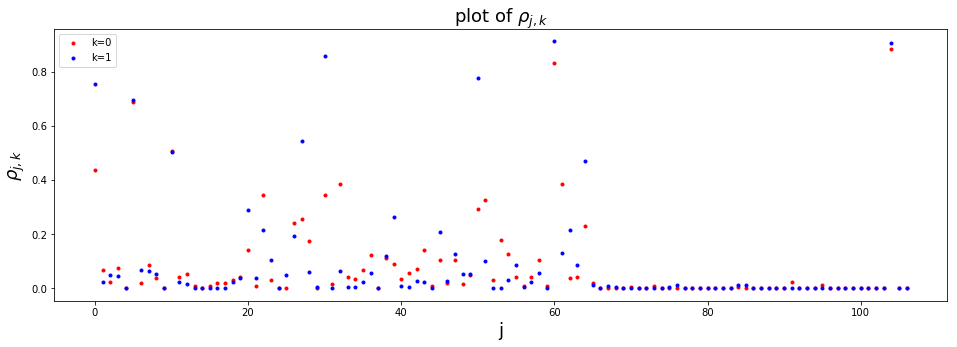

The number of rho's which are zero is 51


In [17]:
# Training by Maximum likelihood
def train_ml(x,y):
    rho1 = x.T.dot(y>0)/sum(y>0)
    rho0 = x.T.dot(y<1)/sum(y<1)
    rho = np.array([rho0,rho1])
    mu = np.mean(y,0)
    return(rho,mu)

# Plot rho
def plot_rho(rho):
    figure = lambda : plt.figure(figsize=(16,5))
    figure()
    plt.plot(rho[0],'r.',label="k=0")
    plt.plot(rho[1],'b.',label="k=1")
    plt.legend(loc='best')
    plt.xlabel('j', fontsize = 18);
    plt.ylabel(r'$\rho_{j,k}$', fontsize = 18);
    plt.title(r'plot of $\rho_{j,k}$',fontsize = 18)
    plt.show()

# Print the number of rho's which are zero
def print_num_rho_0(rho):
    print('The number of rho\'s which are zero is {}'.format(sum(rho.flatten()==0)))
    
# Test
rho, mu = train_ml(X_train,Y_train)
plot_rho(rho)
print_num_rho_0(rho)


## (3 points) 1B: Naive Bayes: Maximum a Posteriori (m.a.p.)
Let $\rho_{j,k}\sim\text{Beta}(\beta)$, with p.d.f. $f_{\rho_{j,k}}(\rho)=\frac{\rho^{\beta-1}(1-\rho)^{\beta-1}}{Z(\beta)}$ where $Z$ is a normalisation factor. Assume a uniform prior for $\mu$.
1. Derive the maximum a posteriori $\rho_{j,k}$ and $\mu$ given the above prior.
- Implement a function which computes these maximum a posteriori parameters.
- Verify with ```assert np.allclose()``` that the m.a.p. solution with $\beta=1$ is identical to the m.l. solution. 
- Call your function on ```X_train, Y_train``` with $\beta=10,100,1000$. For each case scatter plot the m.a.p. parameters vs. the m.l. parameters, all on one axis, colored and labelled appropriately.
- Give one example of the role of $\beta$ as evidenced by the plot.

### <span style="color:blue">Answer</span>
1. Given the continuous prior distribution, the posteriori probability is described in the following equation (P() for the probability of the discrete varible and p() for the probaiblity density function of the continuous varible):
\begin{align}
p(\{\rho_{j,k}\}, \mu|D) &= \dfrac{P(D|\{\rho_{j,k}\}, \mu)p(\{\rho_{j,k}\}, \mu)}{P(D)}\\
\end{align}
Becuase the denominator does not depend on $\rho_{j,k}$ and $\mu$, we can simplify 
$$argmax_{\{\rho_{j,k}\},\mu} \,p(\{\rho_{j,k}\}, \mu|D)$$ 
to 
$$argmax_{\{\rho_{j,k}\},\mu} \,P(D|\{\rho_{j,k}\}, \mu)p(\{\rho_{j,k}\}, \mu).$$
Then, calculate the target function in the argmax.
\begin{align}
P(D|\{\rho_{j,k}\}, \mu)p(\{\rho_{j,k}\}, \mu) &=  p(\{\rho_{j,k}\}, \mu)\prod_{i=1}^{n}P(x_i,y_i|\{\rho_{j,k}\}, \mu) \,\,\,(Different \,data\, are\, independent)\\
& = p(\{\rho_{j,k}\})p(\mu)\prod_{i=1}^{n}P(x_i|y_i,\{\rho_{j,k}\}, \mu)P(y_i|\{\rho_{j,k}\}, \mu)\\
& = p(\mu)[\prod_{j=1}^{d}\prod_{k=0}^{1}p(\rho_{j,k})] \prod_{i=1}^{n}P(y_i|\{\rho_{j,k}\}, \mu)\prod_{j=1}^{d}P(x_{i,j}|y_i,\rho_{j,k}, \mu) \,\,\,(The\, assumption\,of \,Naive\, Bayes)\\
\end{align}
In order to simplify maximization of the posteriori probability, we use ln() for the posteriori probability:
\begin{align}
&\ln [P(D|\{\rho_{j,k}\}, \mu)p(\{\rho_{j,k}\}, \mu)]\\
&=\ln p(\mu) + \sum_{j=1}^{d}\sum_{k=0}^{1} \ln p(\rho_{j,k}) + \sum_{i=1}^{n}\ln P(y_i|\{\rho_{j,k}\}, \mu) + \sum_{i=1}^{n} \sum_{j=1}^{d} \ln P(x_{i,j}|y_i,\rho_{j,k}, \mu)\\
&= \ln p(\mu) + \sum_{j=1}^{d}\sum_{k=0}^{1} [(\beta -1)\ln \rho_{j,k}+(\beta -1)\ln (1-\rho_{j,k})-\ln Z(\beta)] + \\
&\sum_{i=1}^{n}[y_i\ln \mu + (1-y_i)\ln (1 - \mu)]+ \sum_{i=1}^{n} \sum_{j=1}^{d} \lbrace [x_{i,j}\ln \rho_{j,0} + (1-x_{i,j})\ln (1-\rho_{j,0})](1-y_i) + [x_{i,j}\ln \rho_{j,1} + (1-x_{i,j})\ln (1-\rho_{j,1})]y_i \rbrace
\end{align}
In order to get optimal parameters, calculate the partial derivatives with respect to $\rho_{j,k}$ and $\mu$ respectively. 
\begin{align}
&\dfrac{\partial \ln [P(D|\{\rho_{j,k}\}, \mu)p(\{\rho_{j,k}\}, \mu)]}{\partial \rho_{j,0}}\\
&= \dfrac{\beta-1}{\rho_{j,0}} - \dfrac{\beta-1}{1-\rho_{j,0}} + \sum_{i=1}^{n}(\dfrac{x_{i,j}}{\rho_{j,0}}-\dfrac{1-x_{i,j}}{1-\rho_{j,0}})(1-y_i)\\
&= \dfrac{\sum_{i=1}^{n} (x_{i,j}- \rho_{j,0})(1-y_i) + (\beta -1)(1-2\rho_{j,0}) }{\rho_{j,0}(1-\rho_{j,0})}\\
&\dfrac{\partial \ln [P(D|\{\rho_{j,k}\}, \mu)p(\{\rho_{j,k}\}, \mu)]}{\partial \rho_{j,1}}\\
&= \dfrac{\beta-1}{\rho_{j,1}} - \dfrac{\beta-1}{1-\rho_{j,1}} + \sum_{i=1}^{n}(\dfrac{x_{i,j}}{\rho_{j,1}}-\dfrac{1-x_{i,j}}{1-\rho_{j,1}})y_i\\
&= \dfrac{\sum_{i=1}^{n} (x_{i,j}- \rho_{j,1})y_i + (\beta -1)(1-2\rho_{j,1}) }{\rho_{j,1}(1-\rho_{j,1})}\\
&\dfrac{\partial \ln [P(D|\rho_{j,1}, \mu)p(\rho_{j,1}, \mu)]}{\partial \mu}\\
&= \sum_{i=1}^{n}(\dfrac{y_i}{\mu}-\dfrac{1-y_{i}}{1-\mu})\\
&= \dfrac{\sum_{i=1}^{n} y_i - n\mu}{\mu(1-\mu)}
\end{align}
Make the above derivatives zero and we get $\rho_{j,0} = \dfrac{\beta-1+\sum_{i=1}^{n}x_{i,j}(1-y_i)}{2(\beta-1)+n-\sum_{i=1}^{n}y_i}$, $\rho_{j,1} = \dfrac{\beta-1+\sum_{i=1}^{n}x_{i,j}y_i}{2(\beta-1)+\sum_{i=1}^{n}y_i}$ and $\mu = \dfrac{\sum_{i=1}^{n} y_i}{n}$. Bring optimal parameters $\rho_{j,k}$ and $\mu$ into the second derivatives with respect to $\rho_{j,k}$ and $\mu$ respectively and we can see that both are less than zero. Thus, we can say that the parameters gotten above make the posteriori probability maximal.
5. From the images with $\beta$ changing from 10 to 1000, we can see that different $beta$'s can result in different optimal parameters. Thus, we can manipulate $beta$ to get distinctive parameters and then do tests on the cross-validation dataset to see the performance of our model. Finally, select the set of parameters gives best performance on the cross-validation dataset. This is one role that $beta$ plays.

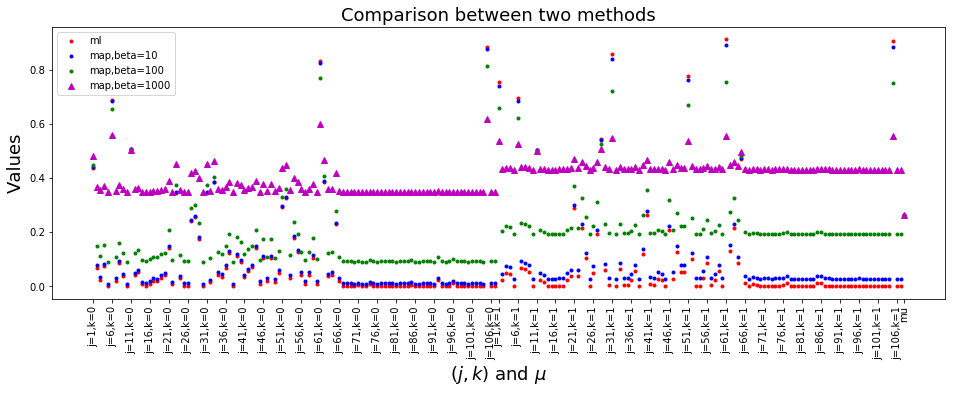

In [18]:
# Training by Maximum a Posteriori
def train_map(X_train, Y_train, beta):
    n = len(Y_train)
    rho0 = (beta-1+X_train.T.dot(Y_train<1))/(2*beta-2+sum(Y_train<1))
    rho1 = (beta-1+X_train.T.dot(Y_train>0))/(2*beta-2+sum(Y_train>0))
    rho = np.array([rho0,rho1])
    mu = sum(Y_train)/n
    return(rho,mu)

# Verify the results
def verify(X_train,Y_train):
    beta = 1
    rho1, mu1 = train_map(X_train,Y_train,beta)
    rho2, mu2 = train_ml(X_train, Y_train)
    assert np.allclose(rho1,rho2),'rho'
    assert np.allclose(mu1,mu2), 'mu'

# Code for question 4    
def map_vs_ml(X_train, Y_train):
    rho_ml,mu_ml = train_ml(X_train, Y_train)
    rho_map1,mu_map1 = train_map(X_train, Y_train, beta=10)
    rho_map2,mu_map2 = train_map(X_train, Y_train, beta=100)
    rho_map3,mu_map3 = train_map(X_train, Y_train, beta=1000)
    
    # Names on x_stick
    d = 5
    n_features = rho_ml.shape[1]
    r1 = range(1,n_features+1,d)
    r2 = range(n_features+1,1+n_features*2,d)
    xlabel = [ 'j={},k={}'.format(j,k) for k in range(2) for j in range(1,1+n_features,d)]
    xlabel = xlabel + ['mu'] 
    
    figure = lambda : plt.figure(figsize=(16,5))
    figure()
    plt.plot(np.append(rho_ml.flatten(),mu_ml),'r.',label="ml")
    plt.plot(np.append(rho_map1.flatten(),mu_map1),'b.',label="map,beta=10")
    plt.plot(np.append(rho_map2.flatten(),mu_map2),'g.',label="map,beta=100")
    plt.plot(np.append(rho_map3.flatten(),mu_map3),'m^',label="map,beta=1000")
    plt.legend(loc='best')
    plt.xlabel(r'$(j,k)$ and $\mu$', fontsize = 18)
    plt.gca().set_xticks([i-1 for j in (r1,r2,[2*n_features+1]) for i in j])
    plt.gca().set_xticklabels(xlabel, rotation='vertical')
    plt.ylabel(r'Values', fontsize = 18);
    plt.title(r'Comparison between two methods',fontsize = 18)
    plt.show()
    

# 3.
verify(X_train, Y_train)

# 4. 
map_vs_ml(X_train, Y_train)

## (2 points) 1C: Naive Bayes: Prediction
1. Derive the log predictive distribution $\log p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu)$. Where appropriate, implement this by adding log probabilities instead of multiplying probabilities. Use ```np.logaddexp``` to add probabilities stored in log space.
- Call the above funcion on ```X_test``` using m.a.p. parameters computed with $\beta=2$.
- Plot a histogram of the probabilities (use ```np.exp``` on the log probabilities) using ```plt.hist``` with ```normed=True,histtype='step',label='your_label'```. Do this for the predictive test probabilities corresponding to ```Y_test==1``` and ```Y_test==0```, puting the histograms on the same plot, labeling appropriately.

### <span style="color:blue">Answer</span>
\begin{align}
&\log p(y=1 | \mathbf{x}, \{\rho_{j,k}\}, \mu)\\
&= \log \dfrac{p(\mathbf{x}|y=1,\{\rho_{j,k}\}, \mu)p(y=1|\{\rho_{j,k}\}, \mu)}{p(\mathbf{x}, y=1|\{\rho_{j,k}\}, \mu)+p(\mathbf{x}, y=0|\{\rho_{j,k}\}, \mu)}\\
&= \log \dfrac{p(y=1|\{\rho_{j,k}\}, \mu) \prod_{j=1}^{d} p(x_j|y=1,\{\rho_{j,k}\}, \mu)}{p(y=1|\{\rho_{j,k}\}, \mu) \prod_{j=1}^{d} p(x_j|y=1,\{\rho_{j,k}\}, \mu) + p(y=0|\{\rho_{j,k}\}, \mu) \prod_{j=1}^{d} p(x_j|y=0,\{\rho_{j,k}\}, \mu)}\\
&= \log \dfrac{\mu \prod_{j=1}^{d} \rho_{j,k=1}^{x_j}(1-\rho_{j,k=1})^{1-x_j}}{\mu \prod_{j=1}^{d} \rho_{j,k=1}^{x_j}(1-\rho_{j,k=1})^{1-x_j}+(1-\mu) \prod_{j=1}^{d} \rho_{j,k=0}^{x_j}(1-\rho_{j,k=0})^{1-x_j}}\\
&= \log\mu + \sum_{j=1}^{d}[x_jlog\rho_{j,k=1}+(1-x_j)\log(1-\rho_{j,k=1})]-\log [\mu \prod_{j=1}^{d} \rho_{j,k=1}^{x_j}(1-\rho_{j,k=1})^{1-x_j}+(1-\mu) \prod_{j=1}^{d} \rho_{j,k=0}^{x_j}(1-\rho_{j,k=0})^{1-x_j}]\\
&= \log\mu + \sum_{j=1}^{d}[x_jlog\rho_{j,k=1}+(1-x_j)\log(1-\rho_{j,k=1})]-\log [e^{\log \mu + \sum_{j=1}^{d} x_j\log \rho_{j,k=1} + (1-x_j)\log(1-\rho_{j,k=1})} + \\ 
&e^{\log(1-\mu) + \sum_{j=1}^{d} x_j\log\rho_{j,k=0}+(1-x_j)\log(1-\rho_{j,k=0})}]\\
\end{align}

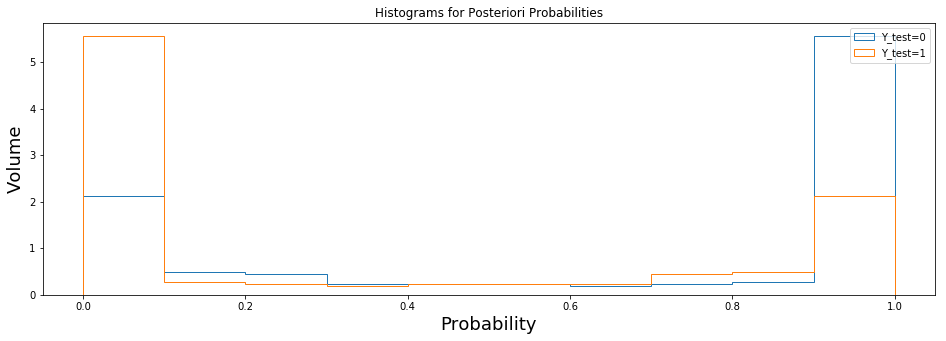

In [19]:
# Log predictive distribution
def predict_distribution(x,rho,mu):
    logp1 = np.log(mu)+x.dot(np.log(rho[1]))+(1-x).dot(np.log(1-rho[1]))
    logp0 = np.log(1-mu)+x.dot(np.log(rho[0]))+(1-x).dot(np.log(1-rho[0]))
    s = np.logaddexp(logp1,logp0)
    return([logp0-s,logp1-s])

# Plot Histograms
def plot_hist(P):
    figure = lambda : plt.figure(figsize=(16,5))
    figure()
    plt.hist(P[0],normed=True,histtype = 'step',label='Y_test=0')
    plt.hist(P[1],normed=True,histtype = 'step',label='Y_test=1')
    plt.legend(loc='best')
    plt.xlabel(r'Probability', fontsize = 18)
    plt.ylabel(r'Volume', fontsize = 18)
    plt.title('Histograms for Posteriori Probabilities')

# For quesiton 2
rho,mu = train_map(X_train, Y_train, beta=2)
res = predict_distribution(X_test,rho,mu)

# For question 3
plot_hist(np.exp(res))

## (2 points) 1D: Naive Bayes: Evaluation
1. Write a function ```evaluate``` which takes data ```X,Y``` and model parameters $\rho_{j,k}$ and $\mu$, and returns a dict with keys ```mean_logp_true``` (for the mean predictive log probability of the ground truth labels ```Y``` given the data matrix ```X``` and ```percent_correct``` (for the percent correctly classified, assuming we classify each datum into the class with maximum predictive probability).
- Write a function ```cross_validate(beta, nfolds, X, Y)``` which performs cross validation with ```nfolds``` folds, for hyper parameter $\beta$. For each split, call your ```evaluate``` function, and return a ```dict``` with averaged results for each evaluation metric. You can make use of our ```xval_inds``` function.
- For $\beta$ in ```np.logspace(np.log10(2),2,32)``` compute the evaluation metrics on the test set, ```X_test, Y_test```, as well as the cross-validated estimates. Make one plot for each metric, showing both results on each (for a total of four curves). Label appropriately.

### <span style="color:blue">Answer</span>

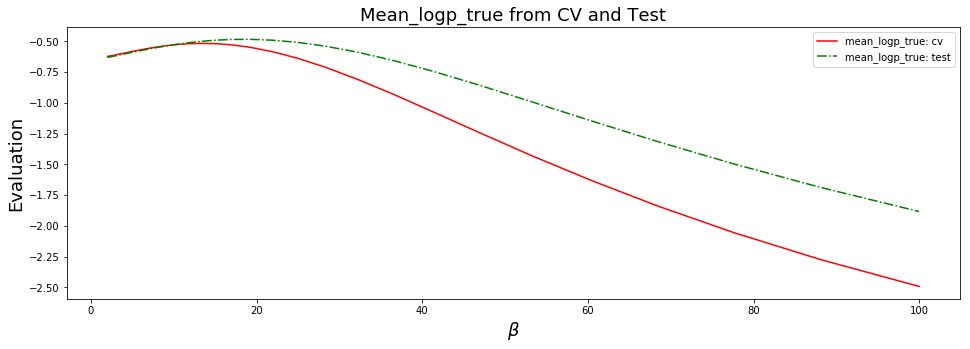

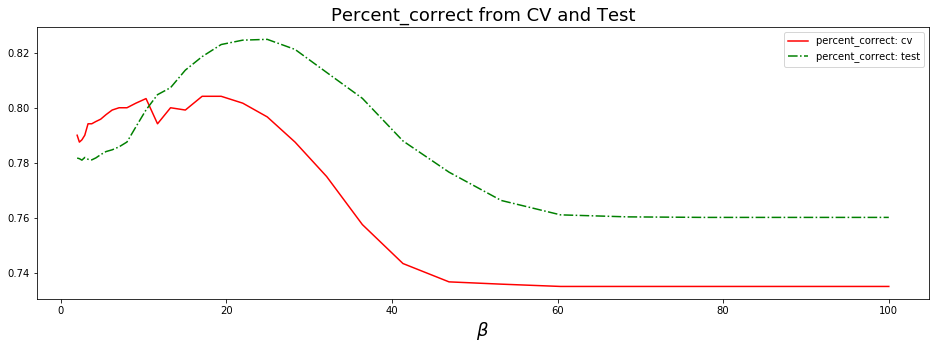

In [20]:
def evaluate(x,y,rho,mu):
    pd = predict_distribution(x,rho,mu)
    res = dict()
    res['mean_logp_true'] =  (y.T.dot(pd[1])+(1-y.T).dot(pd[0]))/len(y)
    res['percent_correct'] = np.mean(y == (pd[1]>pd[0]))
    return(res)
    
def cross_validate(beta,nfolds,X,Y):
    split_id = xval_inds(len(Y),nfolds)
    res = dict()
    res['mean_logp_true'] = 0
    res['percent_correct'] = 0
    
    for ele in split_id:
        x_train = X[ele[0],:]
        y_train = Y[ele[0]]
        x_test = X[ele[1],:]
        y_test = Y[ele[1]]
        rho,mu = train_map(x_train, y_train, beta)
        r1 = evaluate(x_test,y_test,rho,mu)
        res['mean_logp_true'] += r1['mean_logp_true']
        res['percent_correct'] += r1['percent_correct']
    res['mean_logp_true'] /= nfolds
    res['percent_correct'] /= nfolds
    return(res)
    
def xval_inds(ndata, nfolds):
    # return a list of (trainind, testind) pairs for ndata data points and nfolds xval folds
    assert ndata % nfolds == 0
    nchunk = int(ndata / nfolds)
    itest = [list(range(i*nchunk,(i+1)*nchunk)) for i in range(int(nfolds))]
    itrain = [sorted(set(range(ndata)).difference(set(i))) for i in itest]
    return list(zip(itrain, itest))

# For question 3
def experiment():
    nfolds = 5
    betas = np.logspace(np.log10(2),2,32)
    res_cv = []
    res_test = []
    
    for beta in betas:
        res_cv.append(cross_validate(beta,nfolds, X_train, Y_train))
        rho,mu = train_map(X_train, Y_train, beta)
        res_test.append(evaluate(X_test,Y_test,rho,mu))
    
    figure = lambda : plt.figure(figsize=(16,5))
    figure()
    plt.plot(betas, np.array([i['mean_logp_true'] for i in res_cv]).flatten(),'r-',label="mean_logp_true: cv")
    plt.plot(betas, np.array([i['mean_logp_true'] for i in res_test]).flatten(),'g-.',label="mean_logp_true: test")
    plt.legend(loc='best')
    plt.xlabel(r'$\beta$', fontsize = 18)
#     plt.gca().set_xticks(list(range(32)))
#     plt.gca().set_xticklabels(['%.3f'%(i) for i in betas], rotation='vertical')
    plt.ylabel('Evaluation', fontsize = 18);
    plt.title('Mean_logp_true from CV and Test',fontsize = 18)
    plt.show()
    
    figure = lambda : plt.figure(figsize=(16,5))
    figure()
    plt.plot(betas, np.array([i['percent_correct'] for i in res_cv]).flatten(),'r-',label="percent_correct: cv")
    plt.plot(betas, np.array([i['percent_correct'] for i in res_test]).flatten(),'g-.',label="percent_correct: test")
    plt.legend(loc='best')
    plt.xlabel(r'$\beta$', fontsize = 18)
#     plt.gca().set_xticks(list(range(32)))
#     plt.gca().set_xticklabels(['%.3f'%(i) for i in betas], rotation='vertical')
    plt.title('Percent_correct from CV and Test',fontsize = 18)
    plt.show()
    
res = experiment()


## (2 points) 1E: Naive Bayes: Discussion
1. Explain the shortcomings of our preprocessing of (a) continous variables, and (b) categorical variables. Make note of the assumptions of our model.
- Suggest improvements to our data processing pipeline, both in terms of the representation and the model.
- Consider the distribution $p(a,b,c)$ where all three variables are binary. How many parameters are needed to specify this distribution (a) in general and (b) if it factorises as $p(a|c)p(b|c)p(c)$?

### <span style="color:blue">Answer</span>
1. (a) Our preprocessing for continuous variables follows the rule that if larger than the median, it is made 1 and otherwise 0. The problem is the median is chosen based on both of training and test data, which results in the embarrassing situation where even if using the fixed training data, the training results can be different. The reason is that the process breaches the assumption that different data should be independent and the value of a continuous variable in a datum after preprocessing are decided by values of the same variable in the rest data.(b) Categorical variables are processed as indicator vectors. It is clear that entries in the vectors are not independents which destroys Naive Bayes' assumption. This will lead to errors in the calculations afterwards.
2. (a) For a continuous variable, a good way to describe its conditional probability given the class is to assume the probability follow a specific distribution whose parameters are not known. (b) For categorical variables, we can simply use different integers to represent different categories or exploit the categories directly. Naive Bayse classifer will not break down. (c) Classification can be solved not only by Naive Bayes but also some more powerful models, like SVM and Neural Network. In SVM and Neural Network for example, calculations on the features ask all non-numeric features to be converted to numbers.
3. (a) 7 parameters are needed to secify the distribution. Because each variable is binary, there are totally $2^3 = 8$ different cases, each of which are determined by one parameter. Consider that one parameter can be substituded by 1 minus the sum of rest parameters, so the number of needed parameters are 7. (b) Given $p(a,b,c)=p(a|c)p(b|c)p(c)$, we use one parameter for $p(c)$, two parameters for $p(b|c)$ with different c and two parameters for $p(a|c)$ with different c. Thus, the total number of needed parameters is 5.

## (3 points) 2A: Representation Proof
Consider a parametric model governed by the parameter vector $\mathbf{w}$ together with a dataset of input values $\mathbf{x}_1,\ldots,\mathbf{x}_N$ and a nonlinear feature mapping $\phi(\mathbf{x})$. Suppose that the dependence of the error function on $\mathbf{w}$ takes the form $J(\mathbf{w}) = f(\mathbf{w}^\top \phi(\mathbf{x}_1), \ldots, \mathbf{w}^\top \phi(\mathbf{x}_N)) + g(\mathbf{w}^\top \mathbf{w})$
where $g(\cdot)$ is a monotonically increasing function. By writing $\mathbf{w}$ in the form
$$
\mathbf{w} = \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp
$$
show that the value of $\mathbf{w}$ that minimizes $J(\mathbf{w})$ takes the form of a linear combination of the basis functions $\phi(\mathbf{x}_n)$ for $n = 1, \ldots, N$.

### <span style="color:blue">Answer</span>
Given $\mathbf{x_1},...,\mathbf{x_N}$, we can use orthogonal projection to decompose $\mathbf{w}$ into two parts, one lying in $span\{\phi(\mathbf{x_1}),...,\phi(\mathbf{x_N})\}$ and the other lying in the orthogonal component (From Wikipedia: representer theorem). Concretely, $\mathbf{w} = \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp$ and $\langle \mathbf{w}_\perp, \phi (\mathbf{x_i})\rangle = 0$, $i=1,...,N$.

$\mathbf{w}$ minimizing $\mathbf{J(w)}$ can be represented as:
$$
\hat{\mathbf{w}} = argmin_{\mathbf{w}} [f(\mathbf{w}^\top \phi(\mathbf{x}_1), \ldots, \mathbf{w}^\top \phi(\mathbf{x}_N)) + g(\mathbf{w}^\top \mathbf{w})]
$$
Now, let's focus on the two project parts of the above formular.
\begin{align}
\because \, \mathbf{w}^\top \phi(\mathbf{x}_1) =& \langle \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp, \phi(\mathbf{x}_1) \rangle \\
=& \langle \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n), \phi(\mathbf{x}_1) \rangle + \langle \mathbf{w}_\perp, \phi(\mathbf{x}_1) \rangle \\
=& \sum_{n=1}^N \alpha_n \langle \phi(\mathbf{x}_n), \phi(\mathbf{x}_1) \rangle\\
\end{align}
\begin{align}
g(\mathbf{w}^\top \mathbf{w}) =& g(||\sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n)||^2 + ||\mathbf{w}_\perp||^2)
\end{align}
\begin{align}
\therefore f(\mathbf{w}^\top \phi(\mathbf{x}_1), \ldots, \mathbf{w}^\top \phi(\mathbf{x}_N)) = f(\sum_{n=1}^N\langle \alpha_n \phi(\mathbf{x}_n), \phi(\mathbf{x}_1) \rangle,...,\sum_{n=1}^N\langle \alpha_n \phi(\mathbf{x}_N), \phi(\mathbf{x}_1)\rangle) + g(||\sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n)||^2 + ||\mathbf{w}_\perp||^2)
\end{align}
Because $g(\cdot)$ is monotonically increasing function, we set $\mathbf{w}_\perp = \mathbf{0}$ and $g(\cdot)$ and $\mathbf{J(w)}$ can be minimal on a fixed set of $\{a_n\}$. Then, in order to find $argmin_{\mathbf{w}} \mathbf{J(w)}$, we just need to find a set of $\{a_n\}$ to minimize $\mathbf{J(w)}$ with $\mathbf{w}_\perp = \mathbf{0}$. Through this analysis, we prove that value of $\mathbf{w}$ that minimizes $J(\mathbf{w})$ takes the form of a linear combination of the basis functions $\phi(\mathbf{x}_n)$ for $n = 1, \ldots, N$.

## (2 points) Maximum likelihood (ML) and Maximum A Posteriori (MAP)
We assume data samples $X_n = \{ x_1,\dots,x_n \}$ are generated i.i.d. from a uniform distribution
$ \DUniform{x}{0}{\theta} $ between $ 0 $ and an unknown positive parameter $\theta$:
$$
   p(x \Cond \theta) = \DUniform{x}{0}{\theta} = 
\begin{cases}
 1/\theta & 0 \leq x \leq \theta \\
 0        & \textrm{otherwise} \\
\end{cases}
$$

Assume the data samples $ X_4 = \{ 5, 7, 3, 9 \}$ have been observed.

1. Calculate $\theta_{ML} = \argmax_{\theta} p(X_4 \Cond \theta)$, 
the maximum likelihood estimate of $\theta$ for the observed data.

- Calculate $p(\theta \Cond X_4)$, the posterior distribution of $\theta$ given that the 
data $ X_4 $ have been observed and 
the initial distribution for $\theta$ is given as $p(\theta) = p(\theta \Cond X_0) = \DUniform{x}{0}{10}$.

- Calculate $\theta_{MAP} = \argmax_{\theta} p(\theta \Cond X_4)$, the maximum a posteriori
estimate of $\theta$ given the data $ X_4 $ and the initial distribution $p(\theta)$ as in the previous question.

- Calculate $\theta_{ML}$, $p(\theta \Cond X_4)$, and $\theta_{MAP}$ for the case that the observed data are $ X_4 = \{ 9, 5, 7, 3 \}$ instead of the $ X_4 = \{ 5, 7, 3, 9 \}$ given above.

### <span style="color:blue">Answer</span>
1. Because $X_4={5,7,3,9}$ are generated i.i.d, 
$$
p(X_4|\theta) = \prod_{i=1}^{4}p(x_i|\theta) = 
\begin{cases}
 1/\theta^4 & 0 \leq x_i \leq \theta, i = 1,2,3,4 \\
 0        & \textrm{otherwise} \\
\end{cases}
$$
So, in order to maximize the likelihood, $x_i$,$i=1,...,4$ should be in $[0,\theta]$. Now, $p(X_4|
\theta) = \theta^{-4}$ and clearly it increases with $\theta$ declining. Thus, the minimal value $\theta$ can be is 9 and $\theta_{ML} = 9$.
2. Calculate $p(\theta|X_4)$ by:
$$
p(\theta|X_4) = \dfrac{p(X_4|\theta)p(\theta)}{p(X_4)} =
\begin{cases}
 \dfrac{1}{10 \theta^4 p(X_4)} & 0 \leq \theta \leq 10\,\& \,0 \leq x_i\leq\theta, i = 1,2,3,4 \\
 0        & \textrm{otherwise} \\
\end{cases}
$$
3. From the above formula, $\argmax_{\theta} p(\theta \Cond X_4)$ can be transformed as $\argmax_{\theta} \dfrac{1}{10 \theta^4}$. $p(X_4)$ is ignored because it does not depend on $\theta$. Now, it is clear that $\dfrac{1}{10 \theta^4}$ is maximal when $\theta$ is minimal with $0 \leq \theta \leq 10\,\& \,0 \leq x_i\leq\theta, i = 1,2,3,4 $. Thus, $\theta_{MAP} = 9$
4. Based on the previous analysis, $\theta_{ML}$ and $\theta_{MAP}$ are still equal to 9. Also, $p(\theta|X_4)$ does not change at all, i.e.,
$$
p(\theta|X_4) = \dfrac{p(X_4|\theta)p(\theta)}{p(X_4)} =
\begin{cases}
 \dfrac{1}{10 \theta^4 p(X_4)} & 0 \leq \theta \leq 10\,\& \,0 \leq x_i\leq\theta, i = 1,2,3,4 \\
 0        & \textrm{otherwise} \\
\end{cases}
$$

## (2 points) Laplace Approximation
The function
$$
  f(z) = z^k e^{-z^2/2} \qquad \qquad z \in [0, \infty), \qquad k > 0
$$
can be considered as an (unnormalised) probability density.

1. Verify that it is possible to approximate $ f(z) $ with the Laplace Approximation.

- Using the Laplace Approximation, find the mean and the variance of the Normal Distribution which best approximates the normalised version of $ f(z) $.

- The analytical form of the normalisation of $ f(x) $ is not so easy to find. Therefore, use Python to implement a numerical approximation using $ N = 100 $ identically sized intervals between $ 0 $ and $ a = 10 $ to calculate the normalisation 
$$
  \int_0^{\infty} f(z) \mathrm{d}z 
  \approx \int_0^{a} z^k e^{-z^2/2} \mathrm{d}z 
  \approx \sum_{i=1}^{100} \dots
$$
and report the results for the normalisation with a 
precision of $5$ digits after the comma for the three cases $ k = \{0.5, 3, 5 \}$.
            
- For each of the three cases $ k = \{0.5, 3, 5 \}$, plot the normalised function $ f(z) $
and the corresponding Normal Distribution with parameters  resulting from the Laplace Approximation.

- Why is it reasonable to replace the upper limit of $ \infty$ with $ a = 10 $ ?

### <span style="color:blue">Answer</span>
1. $\ln f(z) = k \ln z - z^2/2$. The first and second derivative of $\ln f(z)$ is:
$$
\dfrac{d \ln f(z)}{d z} = \dfrac{k}{z} - z\\
\dfrac{d^2 \ln f(z)}{d z^2} = -\dfrac{k}{z^2} - 1
$$
Because $\dfrac{d^2 \ln f(z)}{d z^2} <0$, we can find a local maximum $z_0$ which makes approximating $f(z)$ with the Laplace Approximation possible. $z_0 = k^{0.5}$ is easy to get from the first derivative. The corresponding $A = 2$.
2. Normalized Laplace Approximation is written as:
$$
f(z) \simeq (\dfrac{A}{2\pi})^{0.5} \exp \{ -0.5A(z-z_0)^2\} = (\dfrac{1}{\pi})^{0.5} \exp \{ -(z-k^{0.5})^2\}
$$
We can see that the variance is $0.5$ and the mean is $k^{0.5}$.

**5.** Replacing the upper limit of $\infty$ with a = 10 is reasonable only when $k$ is small. For exmple for $k = 5$, $f(10) = 1.9287498479639217e-17$ and $f(z)<f(10)$ for $z>10$. In this situation, the main part contributing to the value of integral is located in the interval [0,10] and the integral from 10 to $\infty$ is nearly 0. So, it is reasonable. 

k = 0.5, integral = 1.02387
k = 3.0, integral = 2.00000
k = 5.0, integral = 8.00000


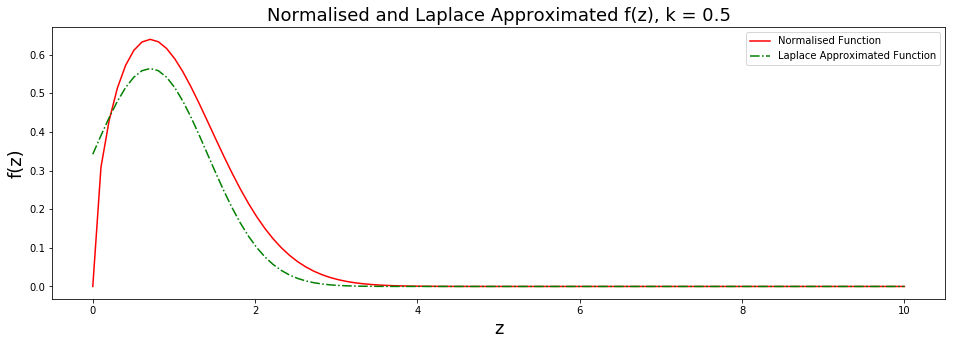

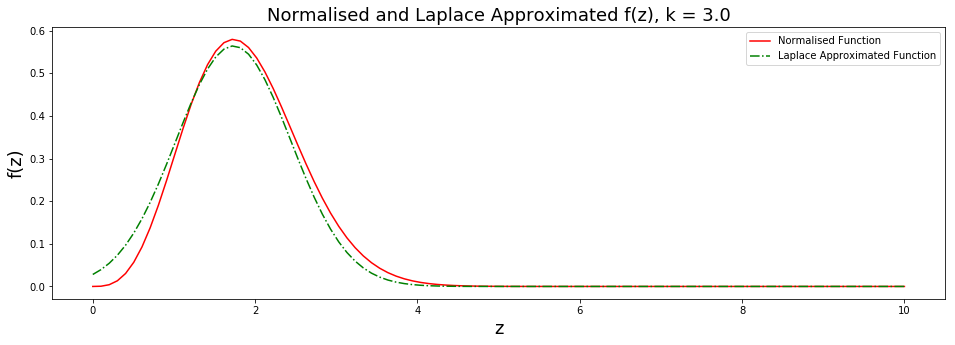

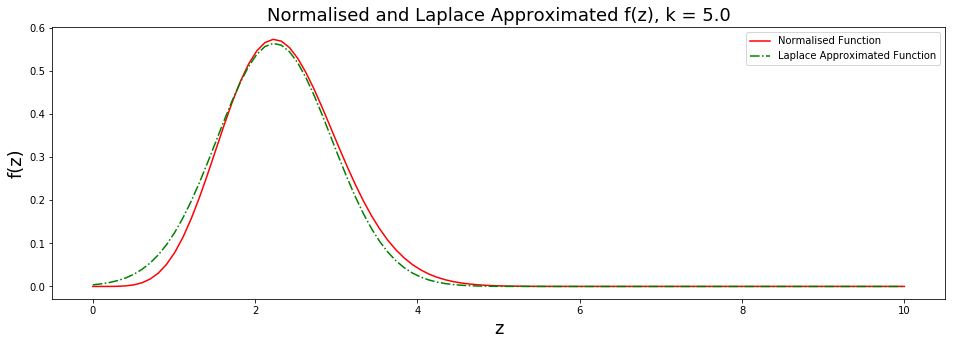

In [21]:
def f(z,k):
    return(z**k*np.exp(-0.5*z*z))

def LA_f(z,k):
    z = z+(z == 0)*1e-8
    f = np.sqrt(1/np.pi)*np.exp(-(z-np.sqrt(k))**2)
    return(f)

def numerical_approximation(a,N,k):
    p = np.linspace(0,a,N+1)
    integ_vect = [(f(p[i],k)+f(p[i+1],k))*(p[i+1]-p[i])/2 for i in range(N)]
    integ = sum(integ_vect)
    return(integ)

def n_f(z,k,norm):
    return(f(z,k)/norm)

def plot_LA_vs_N():
    ks = [0.5,3,5]
    z = np.linspace(0,10,100)
    for k in ks:
        norm = numerical_approximation(10,100,k)
        f1 = n_f(z,k,norm)
        f2 = LA_f(z,k)
        figureure = lambda : plt.figure(figsize=(16,5))
        figure()
        plt.plot(z,f1,'r-',label="Normalised Function")
        plt.plot(z,f2,'g-.',label="Laplace Approximated Function")
        plt.legend(loc='best')
        plt.xlabel('z', fontsize = 18)
        plt.ylabel('f(z)', fontsize = 18)
#         plt.gca().set_xticks(range(0,10,100))
#         plt.gca().set_xticklabels(['%.3f'%(z[i]) for i in range(0,10,100)], rotation='vertical')
        plt.title('Normalised and Laplace Approximated f(z), k = %.1f'%(k),fontsize = 18)
        plt.show()
    
# Q3
ks = [0.5,3,5]
for k in ks:
    print('k = %.1f, integral = %.5f'%(k,numerical_approximation(10,100,k)))
    
# Q4
plot_LA_vs_N()